In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [4]:
# Load your main dataset
# Load the column dictionary
df = pd.read_csv(r"C:\Users\karan\Documents\GitHub\Premier_League\pl_merged_stats.csv")
col_dict = pd.read_csv(r"C:\Users\karan\Documents\GitHub\Premier_League\final_soccer_column_dictionary.csv")

# Create the mapping dictionary
rename_map = dict(zip(col_dict["Column Name"], col_dict["Suggested Column Name"]))

# Rename the columns
df.rename(columns=rename_map, inplace=True)

In [5]:
# Drop all rows where the player position is GK
df = df[df["Player_Position"] != "GK"]

# Optional: reset the index if needed
df.reset_index(drop=True, inplace=True)

df.to_csv("C:\\Users\\karan\\Downloads\\pl_merged_stats_renamed.csv", index=False)

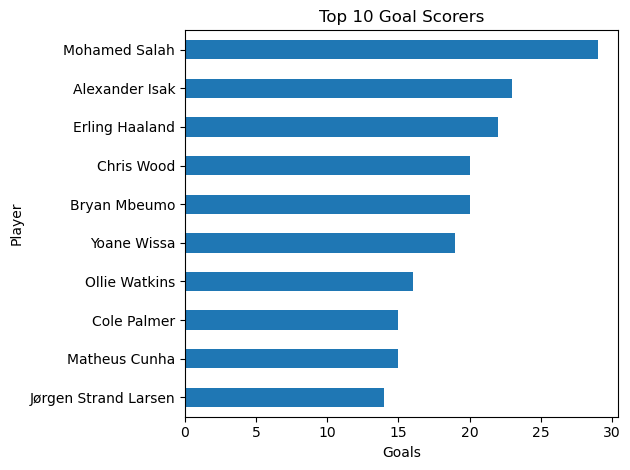

In [6]:
top_scorers = df.groupby("Player")["Goals"].sum().sort_values(ascending=False).head(10)
top_scorers.plot(kind='barh', title="Top 10 Goal Scorers")
plt.xlabel("Goals")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
query = """
SELECT 
    Player,
    Team,
    SUM(Goals) AS Total_Goals,
    SUM(xG) AS Total_Expected_Goals,
    ROUND(SUM(Goals) - SUM(xG), 2) AS Goal_Difference_vs_xG
FROM players
GROUP BY Player, Team
ORDER BY Goal_Difference_vs_xG DESC
"""
player_goal_diff_df = pd.read_sql(query, conn)
# Display top 20 players
player_goal_diff_df.head(20)

,Player,Team,Total_Goals,Total_Expected_Goals,Goal_Difference_vs_xG
0,Bryan Mbeumo,Brentford,20,12.3,7.7
1,Matheus Cunha,Wolves,15,8.3,6.7
2,Chris Wood,Nott'ham Forest,20,13.5,6.5
3,Alex Iwobi,Fulham,9,4.6,4.4
4,Jarrod Bowen,West Ham,13,8.7,4.3
5,Mateo Kovačić,Manchester City,6,1.9,4.1
6,Jørgen Strand Larsen,Wolves,14,10.0,4.0
7,Mohamed Salah,Liverpool,29,25.4,3.6
8,Amad Diallo,Manchester Utd,8,4.6,3.4
9,James Maddison,Tottenham,9,5.7,3.3


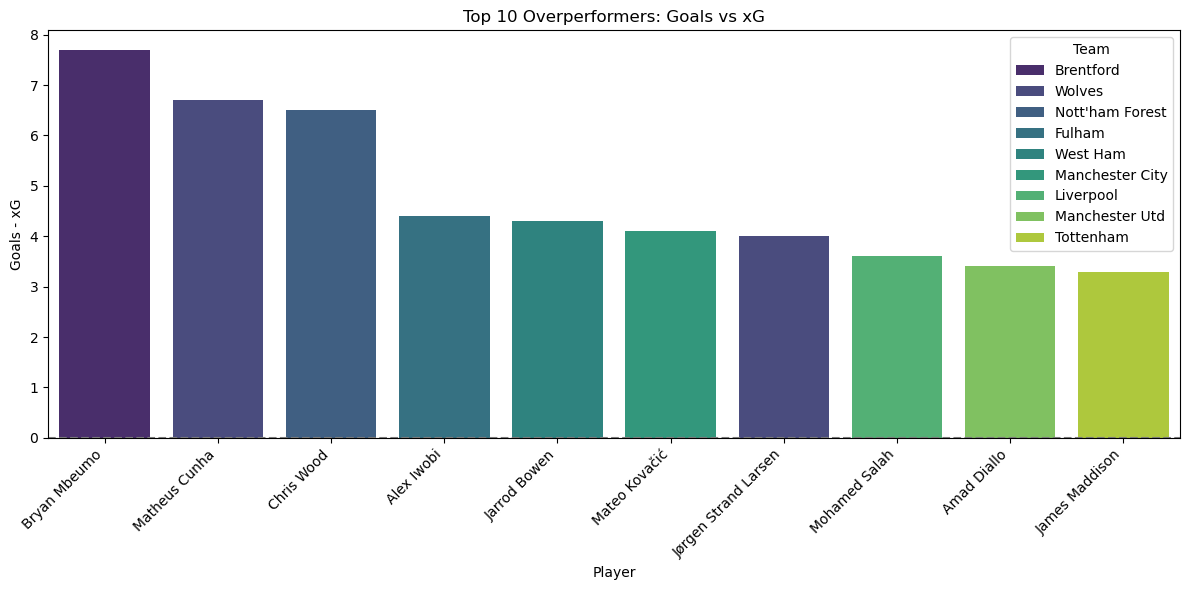

In [25]:
# Top 10 players with highest positive difference
top_overperformers = player_goal_diff_df.sort_values("Goal_Difference_vs_xG", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_overperformers, x="Player", y="Goal_Difference_vs_xG", hue="Team", dodge=False, palette="viridis")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Top 10 Overperformers: Goals vs xG")
plt.xlabel("Player")
plt.ylabel("Goals - xG")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
# Load the renamed CSV (use raw string to avoid backslash errors)
df = pd.read_csv(r"C:\Users\karan\Downloads\pl_merged_stats_renamed.csv")

# Create the in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Load DataFrame into SQL table
df.to_sql("players", conn, index=False, if_exists="replace")

# Run the query
query = """
SELECT Player, SUM(PrgP) AS Total_Progressive_Passes
FROM players
GROUP BY Player
ORDER BY Total_Progressive_Passes DESC
LIMIT 5;
"""

pd.read_sql(query, conn)

,Player,Total_Progressive_Passes
0,Bruno Fernandes,325
1,Bruno Guimarães,271
2,Joško Gvardiol,264
3,Martin Ødegaard,258
4,Youri Tielemans,235


C:\Users\karan\AppData\Local\Temp\ipykernel_21944\2454658600.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_progressive_passers, x="Total_Progressive_Passes", y="Player", palette="viridis")


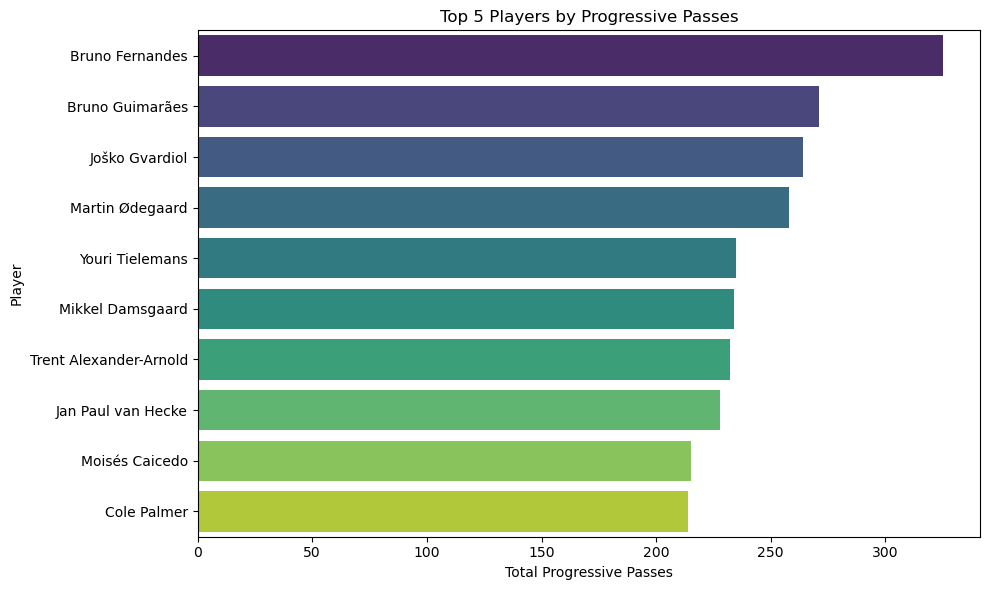

In [8]:
import matplotlib.pyplot as plt

# Run the SQL query and get the result as a DataFrame
query = """
SELECT Player, SUM(PrgP) AS Total_Progressive_Passes
FROM players
GROUP BY Player
ORDER BY Total_Progressive_Passes DESC
LIMIT 10;
"""
top_progressive_passers = pd.read_sql(query, conn)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=top_progressive_passers, x="Total_Progressive_Passes", y="Player", palette="viridis")
plt.title("Top 5 Players by Progressive Passes")
plt.xlabel("Total Progressive Passes")
plt.ylabel("Player")
plt.tight_layout()
plt.show()

In [9]:
query = """
SELECT 
    Player,
    Team,
    SUM(Minutes_Played) AS Total_Minutes,
    ROUND(SUM(Minutes_Played) * 1.0 / 90, 2) AS Nineties_Played,
    COUNT(*) AS Matches_Played,
    SUM(SCA) AS Total_SCA,
    ROUND(SUM(SCA) * 90.0 / SUM(Minutes_Played), 2) AS SCA_per_90
FROM players
WHERE 
    Player_Position LIKE '%LW%' OR
    Player_Position LIKE '%RW%' OR
    Player_Position LIKE '%AM%' OR
    Player_Position LIKE '%CM%' OR
    Player_Position LIKE '%FW%' OR
    Player_Position LIKE '%DM%' OR
    Player_Position LIKE '%LM%' OR
    Player_Position LIKE '%RM%'
GROUP BY Player, Team
HAVING Matches_Played >= 5 AND Total_Minutes >= 1000
ORDER BY SCA_per_90 DESC
"""
sca_combined_df = pd.read_sql(query, conn)

In [14]:
sca_combined_df.head(30)  # shows top 30 rows in table form

,Player,Team,Total_Minutes,Nineties_Played,Matches_Played,Total_SCA,SCA_per_90
0,Bukayo Saka,Arsenal,1729,19.21,25,117,6.09
1,Kevin De Bruyne,Manchester City,1702,18.91,28,113,5.98
2,Bruno Fernandes,Manchester Utd,3018,33.53,36,193,5.76
3,Cole Palmer,Chelsea,3191,35.46,37,202,5.70
4,Sávio,Manchester City,1766,19.62,29,111,5.66
5,Son Heung-min,Tottenham,2110,23.44,30,117,4.99
6,Dejan Kulusevski,Tottenham,2389,26.54,32,128,4.82
7,Martin Ødegaard,Arsenal,2325,25.83,30,124,4.80
8,Christian Eriksen,Manchester Utd,1061,11.79,23,56,4.75
9,Dwight McNeil,Everton,1371,15.23,21,72,4.73


C:\Users\karan\AppData\Local\Temp\ipykernel_21944\1696834557.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=top_players, x="Player", y="SCA_per_90", palette="YlGnBu")


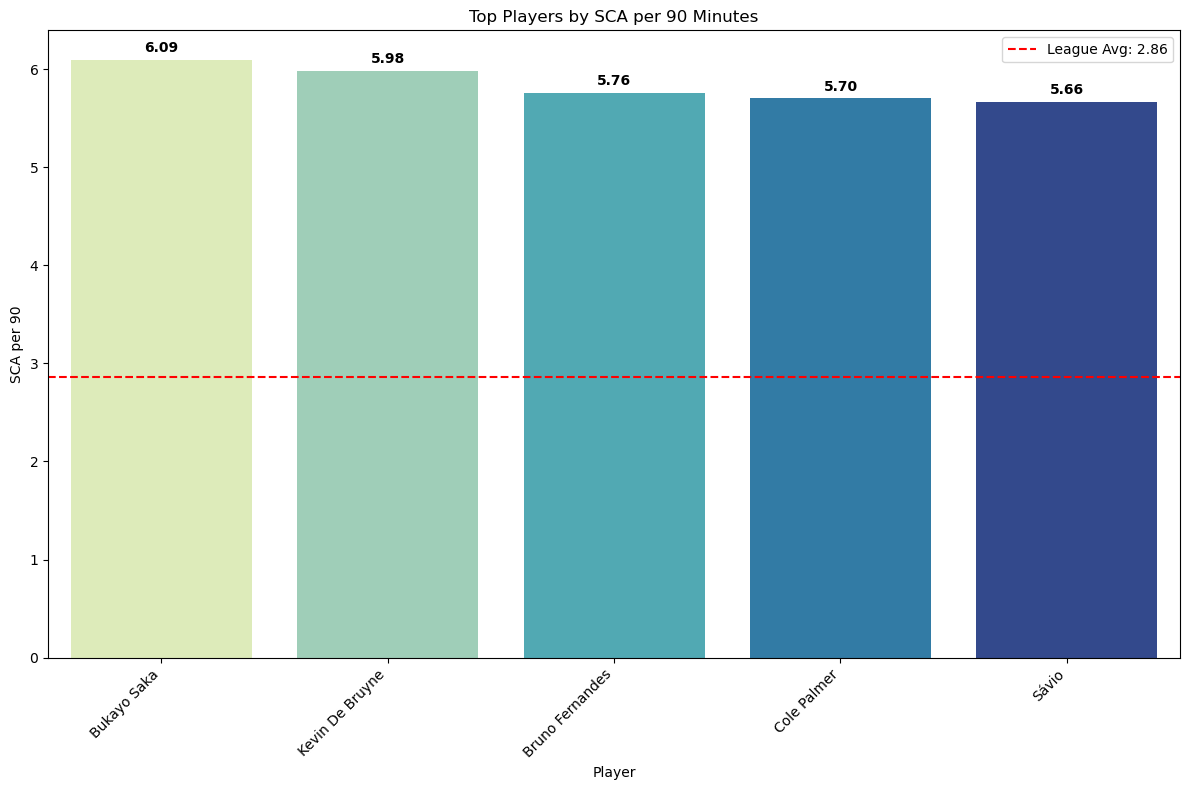

In [20]:

# Sort and pick top 5 players
top_players = sca_combined_df.sort_values("SCA_per_90", ascending=False).head(5)

# Calculate league average
league_avg_sca_90 = sca_combined_df["SCA_per_90"].mean()

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=top_players, x="Player", y="SCA_per_90", palette="YlGnBu")

# Add value labels on top of bars
for i, row in top_players.iterrows():
    barplot.text(
        x=top_players.index.get_loc(i),
        y=row["SCA_per_90"] + 0.05,  # offset above bar
        s=f"{row['SCA_per_90']:.2f}",
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

# Horizontal line for average
plt.axhline(league_avg_sca_90, color='red', linestyle='--', label=f"League Avg: {league_avg_sca_90:.2f}")

plt.title("Top Players by SCA per 90 Minutes")
plt.xlabel("Player")
plt.ylabel("SCA per 90")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()